In [2]:
from imutils.video import VideoStream
import argparse
import imutils
import time
import cv2
import sys
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import utils
import statistics

In [8]:
def camera_test():
    """used to locate all possible usb cameras on device"""
    all_camera_idx_available = []

    for camera_idx in range(0, 2):
        cap = cv2.VideoCapture(camera_idx)
        if cap.isOpened():
            print(f'Camera index available: {camera_idx}')
            all_camera_idx_available.append(camera_idx)
            cap.release()
            
camera_test()

Camera index available: 0
Camera index available: 1


In [9]:
# def calculate_possible_points(tvec_list, width, length):
#     #for every corner, find the intersection
#     corners =[(0, 0), (width, 0), (0, length), (width, length)]
#     possible_points = []
#     point_tvec = tvec_list[4]
#     for i in range(4):
#         for j in range(i+1, 4):
#             x0, y0 = corners[i]
#             r0 = np.linalg.norm(point_tvec-tvec_list[i])
#             x1, y1 = corners[j]
#             r1 = np.linalg.norm(point_tvec-tvec_list[j])
#             returned = get_intersections(x0, y0, r0, x1, y1, r1)
#             if returned != None:
#                 point1, point2 = returned
#                 possible_points.append([point1, point2])
#     return possible_points

def clean_points_and_vote1(width, length, box_size, possible_points):
    block_width = width/box_size
    block_length = length/box_size
    possible_coords = [0]*box_size*box_size
    max_votes = 0
    max_vote_index = -1;
    #x = math.floor(x/block_width)
    #y = math.floor(y/block_length)
    definite_points = []
    sus_points = []
    for pair in possible_points:
        point1, point2 = pair
    
        if point1[0] > 0 and point1[1] > 0 and point2[0] > 0 and point2[1] > 0:
            # both in bounds, sus
            sus_points.append(pair)
            continue
        if point2[0] > 0 and point2[1] > 0 and (point1[0] < 0 or point1[1] < 0):
            #2 in bounds, 1 not
            definite_points.append(point2)
            continue
        if point1[0] > 0 and point1[1] > 0 and (point2[0] < 0 or point2[1] < 0):
            #1 in bounds, 2 not
            definite_points.append(point1)
            continue
        #if neither is in, then neither is possible
        
#     print('these are definite')
#     print(definite_points)
#     print('these are sus')
#     for pair in sus_points:
#         print(pair)
#     print('these are the final ones')
    if len(definite_points) > 0:
        # filter by distance
        xavg = 0
        yavg = 0
        for point in definite_points:
            xavg += point[0]
            yavg += point[1]
        xavg = xavg/len(definite_points)
        yavg = yavg/len(definite_points)
        avgpt = [xavg, yavg]
        
        for pair in sus_points:
            dist0 = utils.find_distance(pair[0], avgpt)
            dist1 = utils.find_distance(pair[1], avgpt)
            if dist0 < dist1:
                definite_points.append(pair[0])
            else:
                definite_points.append(pair[1])
        
        
        #final average
        xavg = 0
        yavg = 0
        for point in definite_points:
            xavg += point[0]
            yavg += point[1]
        xavg = xavg/len(definite_points)
        yavg = yavg/len(definite_points)
        print(definite_points)
        return 0, xavg, yavg
    else:
         # otherwise just take all of them 
        print('fuck')
        return 0, 0 ,0
    
#     for x, y in possible_points:
#         if x < 0 or y < 0:
#             continue 
        
#         if x > box_size-1 or y > box_size-1:
#             continue
#         # debug print
#         # print(str(x) + ' ' + str(y))
#         possible_coords[ y * box_size + x] += 1
#         if possible_coords[ y * box_size + x] > max_votes:
#             max_votes = possible_coords[ y * box_size + x]
#             max_vote_index =  y * box_size + x
#     x_avg = []
#     y_avg = []
    
#     for x, y in possible_points:
#         if x < 0 or y < 0:
#             continue 
#         roundx = math.floor(x/block_width)
#         roundy = math.floor(y/block_length)
#         if roundx > box_size-1 or roundy > box_size-1:
#             continue
# #         if roundy * box_size + roundx == max_vote_index:
# #             x_avg.append(x)
# #             y_avg.append(y)
#         x_avg.append(x)
#         y_avg.append(y)
#    return 0, sum(x_avg)/len(x_avg), sum(y_avg)/len(y_avg)


def clean_points_and_vote2(width, length, box_size, possible_points):
    block_width = width/box_size
    block_length = length/box_size
    possible_coords = [0]*box_size*box_size
    max_votes = 0
    max_vote_index = -1;
    #x = math.floor(x/block_width)
    #y = math.floor(y/block_length)
    midpoints = []
    for pair in possible_points:
        point1, point2 = pair
        midpoint = [(point1[0] + point2[0])/2, (point1[1] + point2[1])/2]
        midpoints.append(midpoint)
    x_mids = [point[0] for point in midpoints]
    y_mids = [point[1] for point in midpoints]
    return 0, statistics.median(x_mids), statistics.median(y_mids)

def clean_points_and_vote3(width, length, box_size, possible_points):
    x_mids = [point[0] for point in possible_points]
    y_mids = [point[1] for point in possible_points]
    return 0, statistics.median(x_mids), statistics.median(y_mids)

In [10]:
def calculate_possible_points(tvec_list, width, length):
    #for every corner, find the intersection
    corners =[(0, 0), (width, 0), (0, length), (width, length)]
    possible_points = []
    point_tvec = tvec_list[4]
    for i in range(4):
        for j in range(i+1, 4):
            x0, y0 = corners[i]
            r0 = np.linalg.norm(point_tvec-tvec_list[i])
            x1, y1 = corners[j]
            r1 = np.linalg.norm(point_tvec-tvec_list[j])
            returned = utils.get_intersections(x0, y0, r0, x1, y1, r1)
            if returned != None:
                point1, point2 = returned
                possible_points.append([point1, point2])
    return possible_points

[ 2.68227047 -0.04511594 -0.2959517 ]
[ 3.03618136 -0.33711612 -0.1659986 ]
[ 3.12941073  0.13430033 -0.11131242]
[-1.88664642  0.19329612  0.9771626 ]
[ 2.18475899 -2.11206029 -0.01834332]
[[0.10623561676842085, 0.17375752245346385], [0.20335680464966668, 0.011121730171608987], [0.06749821037179216, 0.10208032233540473]]
0.34206319850758427
0.36523854843411035
location 1: 0.33072014186423987 0.23570313937898493
location 2: 0.2720641224054308 0.2580764962436315
location 3: 0.22855490609394635 0.3398519424829649
location 0: 0.33072014186423987 0.23570313937898493


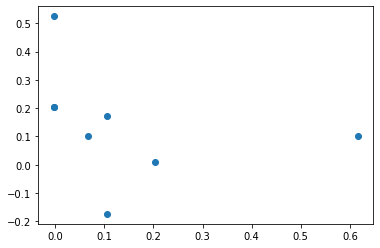

In [11]:
vs = VideoStream(src=0).start()
time.sleep(1.0)
frame = vs.read()
arucoDict = cv2.aruco.DICT_4X4_50
mtx, dist = utils.load_coefficients('calibration_aruco1.yml')

image = imutils.resize(frame, width = 1000)
#(corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)
output, rvecs, tvecs= utils.pose_estimation(image, arucoDict, mtx, dist)

#cv2.destroyAllWindows()
tvec_list, rvec_list = utils.clean_tvec_rvec(tvecs, rvecs)
for rvec in rvec_list:
    print(rvec)
if len(tvec_list) != 5:
    print("[ERROR] not all markers were detected, trying again later")
width, length, a, b, c, d = utils.get_width_length(tvec_list)
possible_points = calculate_possible_points(tvec_list, width, length)
pp = utils.calculate_possible_points(tvec_list, width, length)
#print(possible_points)
propx = .9/width
propy = .9/length

prediction, x, y = clean_points_and_vote1(width, length, 3, possible_points)
#angle = utils.diff_y_angle(rvec_list)

prop = (propx+propy)/2
print(width)
print(length)
print('location 1: ' + str(propx*x) + ' ' + str(propy*y))


prediction, x, y = clean_points_and_vote2(width, length, 3, possible_points)
print('location 2: ' + str(propx*x) + ' ' + str(propy*y))

prediction, x, y = clean_points_and_vote3(width, length, 3, pp)
print('location 3: ' + str(propx*x) + ' ' + str(propy*y))

prediction, x, y = utils.clean_points_and_vote(width, length, 3, pp)
print('location 0: ' + str(propx*x) + ' ' + str(propy*y))
#cv2.imshow('test', output)
#cv2.waitKey(0)
vs.stop()

ppx = [point[0] for point in pp]
ppy = [point[1] for point in pp]
plt.scatter(ppx, ppy)
plt.show()

In [14]:
import numpy as np
import math
import cv2
#import
#import tf.transformations
#from geometry_msgs.msg import PoseStamped

rvec = rvec_list[4]
tvec = tvecs[4]
def y_angle(rvec):
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    def rotationMatrixToEulerAngles(R) :
        sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
        singular = sy < 1e-6
        if not singular :
            x = math.atan2(R[2,1] , R[2,2])
            y = math.atan2(-R[2,0], sy)
            z = math.atan2(R[1,0], R[0,0])
        else :
            x = math.atan2(-R[1,2], R[1,1])
            y = math.atan2(-R[2,0], sy)
            z = 0
        return np.array([x, y, z])

    euler = rotationMatrixToEulerAngles(rotation_matrix)
    euler_degrees = [180*item/3.14159 for item in euler]
    return euler_degrees[2]
y_angle(rvec)

-87.91332224718037

In [10]:
for pair in possible_points:
    print(pair)

[[0.16864386516223126, -0.18365575612277849], [0.16864386516223126, 0.18365575612277849]]
[[0.16319140047659383, 0.18851725869101293], [-0.16319140047659383, 0.18851725869101293]]
[[0.19965511668638508, 0.14935871047525912], [0.07888749192140748, 0.23653108386052812]]
[[0.16125750317755283, 0.18318564182647495], [0.007598177097622935, 0.0722714115165241]]
[[0.2421792541900783, 0.17174322289958552], [0.11107019619735363, 0.17174322289958552]]
[[0.1454053048066435, 0.15171785409089267], [0.1454053048066435, 0.33766995785129217]]


In [ ]:
arucoDict = cv2.aruco.DICT_4X4_50
mtx, dist = utils.load_coefficients('calibration_aruco1.yml')

print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)
while True:
    time.sleep(1.0)
    frame = vs.read()

    image = imutils.resize(frame, width = 1000)
    #(corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)
    output, rvecs, tvecs= utils.pose_estimation(image, arucoDict, mtx, dist)
    
    #cv2.destroyAllWindows()
    tvec_list, rvec_list = utils.clean_tvec_rvec(tvecs, rvecs)
    if len(tvec_list) != 5:
        print("[ERROR] not all markers were detected, trying again later")
        continue
    width, length, a, b, c, d = utils.get_width_length(tvec_list)
    possible_points = utils.calculate_possible_points(tvec_list, width, length)
    print(possible_points)
    prediction, x, y = utils.clean_points_and_vote(width, length, 3, possible_points)
    #prediction, x, y = clean_points_and_vote1=(width, length, 3, possible_points)
    angle = utils.diff_y_angle(rvec_list)
    #prop = .75/width
    propx = .9/width
    propy = .9/length
    print(width)
    print(length)
    print('location ' + str(propx*x) + ' ' + str(propy*y))
    print('predicted box: ' + str(prediction))
    print('angle: ' + str(angle))
    cv2.imshow('test', output)
    cv2.waitKey(0)
    input('press enter to continue')
    
cv2.destroyAllWindows()
vs.stop()

[INFO] starting video stream...
[[0.07750385583750022, -0.2756393603293838], [0.07750385583750022, 0.2756393603293838], [0.13860487707368427, 0.25054459220637904], [-0.13860487707368427, 0.25054459220637904], [0.1777395607213831, 0.3405014059275294], [0.00453799312615269, 0.18506117462048519], [0.49545470688510435, 0.331399268230626], [0.1584904549463682, 0.331399268230626], [0.1675973697048424, 0.3005338083923538], [0.1675973697048424, 0.4281342217445441]]
0.3269725809157363
0.3643340150684489
location 0.3323554421815422 0.6931879292373115
predicted box: 7
angle: -143.09618581614325


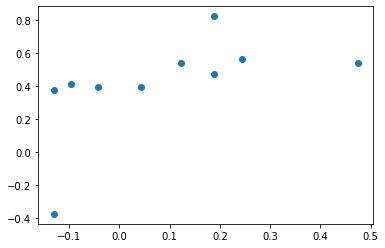

In [6]:


import numpy as np
import matplotlib.pyplot as plt

ppx = [point[0] for point in pp]
ppy = [point[1] for point in pp]
plt.scatter(ppx, ppy)
plt.show()



In [4]:
from imutils.video import VideoStream
import argparse
import imutils
import time
import cv2
import sys
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import utils
import statistics

    

def find_location(tags, distances):
    A = []
    b = []
    for i in range(1, len(tags)):
        #print(i)
        A.append([2 * (tags[0][0] - tags[i][0]), 2 * (tags[0][1] - tags[i][1])])
        b.append(np.linalg.norm(tags[0]) ** 2 - np.linalg.norm(tags[i]) ** 2 - distances[0] ** 2 + distances[i] ** 2)
    return np.linalg.lstsq(A, b)[0]
    
def calculate_location(tvec_list, width, length):
    #for every corner, find the intersection
    point_tvec = tvec_list[4]
    corners =[(0, length), (width, length), (0, 0), (width, 0)]
    distances = []
    for i in range(len(corners)):
        print(i)
        distance = np.linalg.norm(point_tvec-tvec_list[i])
        print(distance)
        distances.append(distance)
    return find_location(corners, distances)



In [5]:
vs = VideoStream(src=0).start()
time.sleep(1.0)
frame = vs.read()
arucoDict = cv2.aruco.DICT_4X4_50
mtx, dist = utils.load_coefficients('calibration_aruco1.yml')

image = imutils.resize(frame, width = 1000)
#(corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)
output, rvecs, tvecs= utils.pose_estimation(image, arucoDict, mtx, dist)

#cv2.destroyAllWindows()
tvec_list, rvec_list = utils.clean_tvec_rvec(tvecs, rvecs)
for rvec in rvec_list:
    print(rvec)
if len(tvec_list) != 5:
    print("[ERROR] not all markers were detected, trying again later")
width, length, a, b, c, d = utils.get_width_length(tvec_list)

print(width)
print(length)
propx = .9/width
propy = .9/length
pp = calculate_location(tvec_list, width, length)
print('x')
print(pp[0])
print('y')
print(pp[1])
vs.stop()

[ 2.68227047 -0.04511594 -0.2959517 ]
[ 3.03618136 -0.33711612 -0.1659986 ]
[ 3.12941073  0.13430033 -0.11131242]
[-1.88664642  0.19329612  0.9771626 ]
[ 2.18475899 -2.11206029 -0.01834332]
0.34206319850758427
0.36523854843411035
0
0.2036607052902763
1
0.2929271665757681
2
0.15982680182360426
3
0.3803132717555688
x
0.06980719438931733
y
0.19492434044230494


/var/folders/j_/rmvg8zw52690s8m6b80w4jn80000gn/T/ipykernel_22568/2254825388.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(A, b)[0]


In [15]:

def find_location(tags, distances):
    A = []
    b = []
    for i in range(1, len(tags)):
        #print(i)
        A.append([2 * (tags[0][0] - tags[i][0]), 2 * (tags[0][1] - tags[i][1])])
        b.append(np.linalg.norm(tags[0]) ** 2 - np.linalg.norm(tags[i]) ** 2 - distances[0] ** 2 + distances[i] ** 2)
    return np.linalg.lstsq(A, b)[0]
        
find_location([(0,0),(0,1),(1,0),(1,1)], [0.7, 0.7, 0.7, 0])

1
2
3


/var/folders/j_/rmvg8zw52690s8m6b80w4jn80000gn/T/ipykernel_21494/1934276266.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(A, b)[0]


array([0.58166667, 0.58166667])